In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter, freqz
from scipy.io import wavfile
import sounddevice as sd
import os

# — Parameters —
SAMPLING_RATE      = 44100
RECORD_DURATION    = 10
NOISE_AMPLITUDE    = 0.05   

CUTOFF_FREQ_LPF    = 7000
FILTER_ORDER_LPF   = 300
NUM_TAPS_LPF       = FILTER_ORDER_LPF + 1

ORIGINAL_AUDIO_FILE = "original_audio.wav"
NOISY_AUDIO_FILE    = "noisy_audio.wav"
FILTERED_AUDIO_FILE = "filtered_audio.wav"


In [22]:
# — Langkah Rekam —
if not os.path.exists(ORIGINAL_AUDIO_FILE):
    print(f"Mulai merekam selama {RECORD_DURATION}s…")
    rec = sd.rec(int(RECORD_DURATION * SAMPLING_RATE),
                 samplerate=SAMPLING_RATE,
                 channels=1,
                 dtype='float32')
    sd.wait()
    wavfile.write(ORIGINAL_AUDIO_FILE,
                  SAMPLING_RATE,
                  (rec * np.iinfo(np.int16).max).astype(np.int16))
    print(f"Tersimpan: {ORIGINAL_AUDIO_FILE}")
else:
    print(f"Menggunakan file: {ORIGINAL_AUDIO_FILE}")

Mulai merekam selama 10s…
Tersimpan: original_audio.wav


In [23]:
# — Langkah Noise —
fs, data_int = wavfile.read(ORIGINAL_AUDIO_FILE)
audio = data_int.astype(np.float32) / np.iinfo(np.int16).max
noise = NOISE_AMPLITUDE * np.random.normal(size=len(audio))
noisy = np.clip(audio + noise, -1.0, 1.0)
wavfile.write(NOISY_AUDIO_FILE,
              fs,
              (noisy * np.iinfo(np.int16).max).astype(np.int16))
print(f"Tersimpan: {NOISY_AUDIO_FILE}")

Tersimpan: noisy_audio.wav


In [24]:
# — Langkah Filter & Simpan —
norm_cutoff = CUTOFF_FREQ_LPF / (SAMPLING_RATE / 2)
fir_coeff = firwin(NUM_TAPS_LPF, norm_cutoff, window='hamming')
filtered = lfilter(fir_coeff, 1.0, noisy)
wavfile.write(FILTERED_AUDIO_FILE,
              SAMPLING_RATE,
              (filtered * np.iinfo(np.int16).max).astype(np.int16))
print(f"Tersimpan: {FILTERED_AUDIO_FILE}")

Tersimpan: filtered_audio.wav


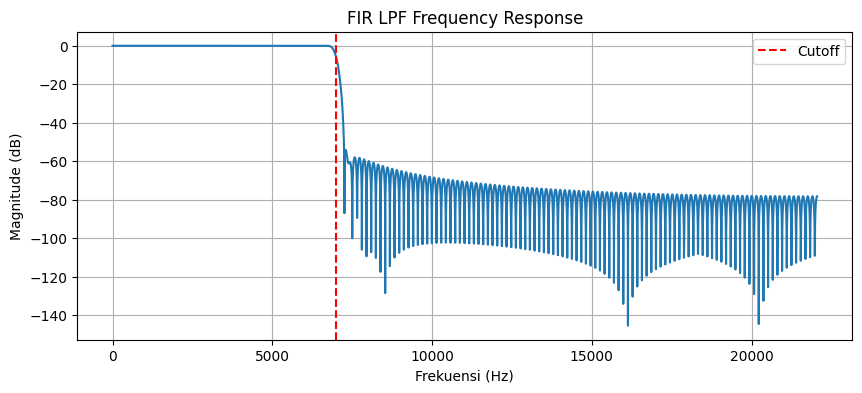

In [25]:
# — Plot Frequency Response Filter —
w, h = freqz(fir_coeff, worN=8000)
freqs = w * SAMPLING_RATE / (2 * np.pi)
plt.figure(figsize=(10,4))
plt.plot(freqs, 20*np.log10(abs(h)))
plt.axvline(CUTOFF_FREQ_LPF, color='red', linestyle='--', label='Cutoff')
plt.title('FIR LPF Frequency Response')
plt.xlabel('Frekuensi (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.legend()
plt.show()

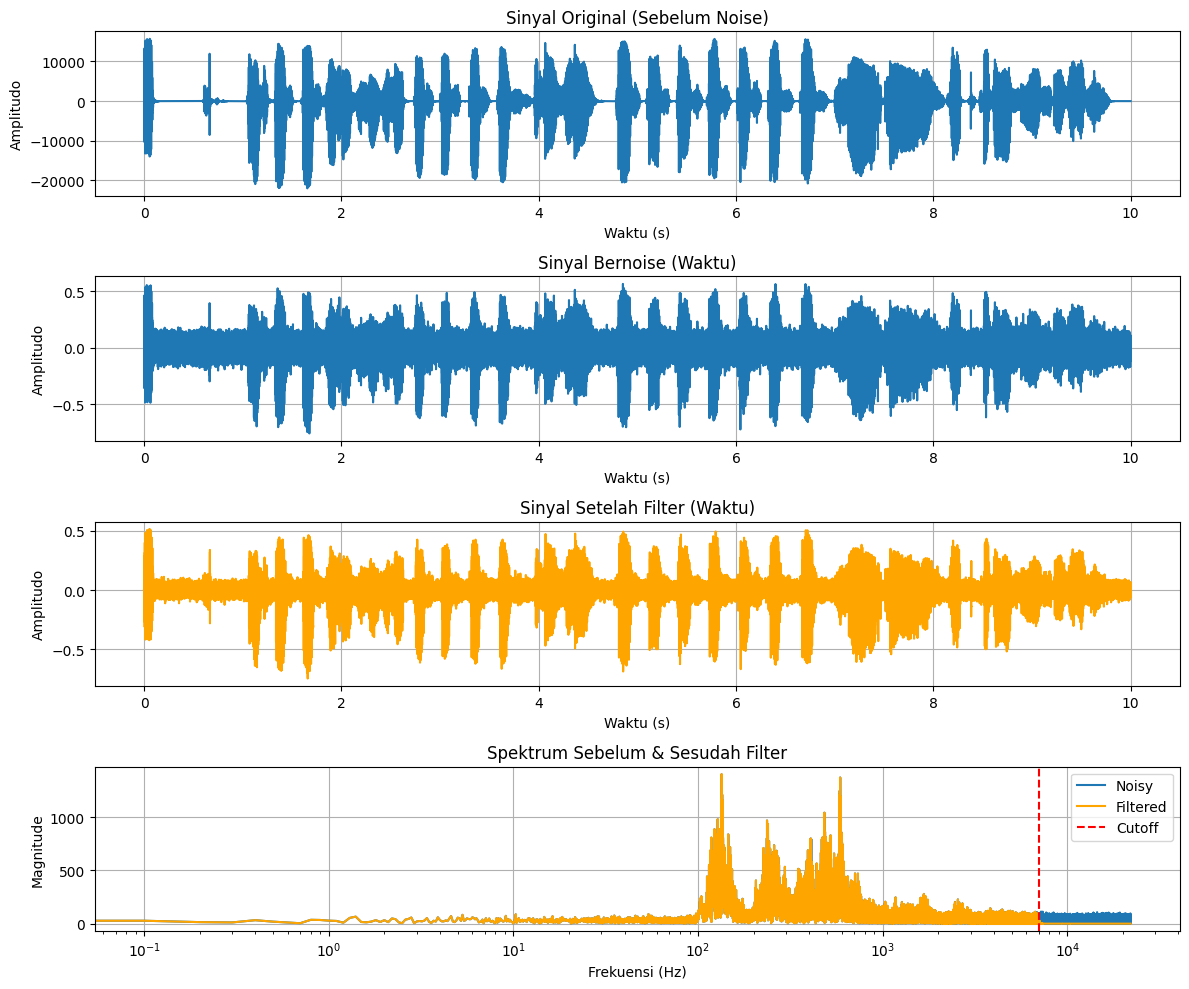

In [26]:


# — Plot Sinyal (Waktu & Frekuensi) dengan Original, Noisy, Filtered —
t = np.arange(len(data_int)) / SAMPLING_RATE
f_axis = np.fft.rfftfreq(len(t), 1/SAMPLING_RATE)

plt.figure(figsize=(12,10))

# 1) Original sebelum noise
plt.subplot(4,1,1)
plt.plot(t, data_int)
plt.title('Sinyal Original (Sebelum Noise)')
plt.xlabel('Waktu (s)')
plt.ylabel('Amplitudo')
plt.grid(True)

# 2) Sinyal setelah noise
plt.subplot(4,1,2)
plt.plot(t, noisy)
plt.title('Sinyal Bernoise (Waktu)')
plt.xlabel('Waktu (s)')
plt.ylabel('Amplitudo')
plt.grid(True)

# 3) Sinyal setelah filter
plt.subplot(4,1,3)
plt.plot(t, filtered, color='orange')
plt.title('Sinyal Setelah Filter (Waktu)')
plt.xlabel('Waktu (s)')
plt.ylabel('Amplitudo')
plt.grid(True)

# 4) Spektrum sebelum & sesudah filter
plt.subplot(4,1,4)
plt.semilogx(f_axis, np.abs(np.fft.rfft(noisy)), label='Noisy')
plt.semilogx(f_axis, np.abs(np.fft.rfft(filtered)), label='Filtered', color='orange')
plt.axvline(CUTOFF_FREQ_LPF, color='red', linestyle='--', label='Cutoff')
plt.title('Spektrum Sebelum & Sesudah Filter')
plt.xlabel('Frekuensi (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
